In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

In [68]:
# Define the path to the dataset in Google Drive
dataset_path = '/content/drive/My Drive/GMBAMU-IRIS DATASET'
age_groups = ['Age 1-10', 'Age 11-20', 'Age 21-30', 'Age 31-40', 'Age 41-50', 'Age 51-60', 'Age 61-70', 'Age 71-80']


In [69]:
# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    age_labels = []
    gender_labels = []
    for age_group in age_groups:
        age_path = os.path.join(folder, age_group)
        # if age_group == 'Age 21-30':
        #     # Handle unlabeled data separately
        #     unlabeled_path = os.path.join(age_path, 'Unlabeled Data(GenderNotMentioned)')
        #     if os.path.exists(unlabeled_path) and os.path.isdir(unlabeled_path):
        #         for subject_folder in os.listdir(unlabeled_path):
        #             subject_path = os.path.join(unlabeled_path, subject_folder, 'Iris')
        #             if os.path.isdir(subject_path):
        #                 for img_name in os.listdir(subject_path):
        #                     img_path = os.path.join(subject_path, img_name)
        #                     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        #                     if img is not None:
        #                         img = cv2.resize(img, (64, 64))  # Resize to 64x64
        #                         images.append(img)
        #                         age_labels.append(age_group)
        #                         gender_labels.append('Unknown')
        # Process labeled data
        for gender in ['Female_iris', 'Male_Iris']:
            gender_path = os.path.join(age_path, gender)
            if not os.path.exists(gender_path) or not os.path.isdir(gender_path):
                continue
            for subject_folder in os.listdir(gender_path):
                subject_path = os.path.join(gender_path, subject_folder)
                if os.path.isdir(subject_path):
                    for img_name in os.listdir(subject_path):
                        img_path = os.path.join(subject_path, img_name)
                        if img_name == '.DS_Store' or not img_name.endswith(('.jpg', '.jpeg', '.png')):
                            continue  # Skip hidden and non-image files
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                        if img is not None:
                            img = cv2.resize(img, (64, 64))  # Resize to 64x64
                            images.append(img)
                            age_labels.append(age_group)
                            gender_labels.append(gender.split('_')[0])  # Extract gender from folder name
    return np.array(images), age_labels, gender_labels


In [70]:
# Load data
images, age_labels, gender_labels = load_images_from_folder(dataset_path)


In [96]:
print(age_labels[2863])

[0. 0. 0. 0. 0. 0. 0. 1.]


In [71]:
# Encode labels
age_encoder = LabelEncoder()
gender_encoder = LabelEncoder()

age_labels = age_encoder.fit_transform(age_labels)
gender_labels = gender_encoder.fit_transform(gender_labels)

In [72]:
# Convert age labels to categorical
age_labels = tf.keras.utils.to_categorical(age_labels, num_classes=len(age_groups))

In [73]:
# Normalize images
images = images / 255.0  # Normalize pixel values to [0, 1]
images = images.reshape(images.shape[0], 64, 64, 1)  # Reshape for CNN input


In [74]:
# Print sample data for debugging
print("Sample image shape:", images[0].shape)
print("Sample age label:", age_labels[0])
print("Sample gender label:", gender_labels[0])

Sample image shape: (64, 64, 1)
Sample age label: [1. 0. 0. 0. 0. 0. 0. 0.]
Sample gender label: 0


In [75]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(images, list(zip(age_labels, gender_labels)), test_size=0.2, random_state=42)

In [76]:
# Separate age and gender labels for training and testing
y_train_age = np.array([y[0] for y in y_train])
y_train_gender = np.array([y[1] for y in y_train])
y_test_age = np.array([y[0] for y in y_test])
y_test_gender = np.array([y[1] for y in y_test])

In [77]:
# Define the CNN model with batch normalization and dropout
def create_cnn():
    cnn = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5)  # Add dropout
    ])
    return cnn

In [78]:
# Define the RNN/Attention model
def create_rnn():
    rnn = models.Sequential([
        layers.LSTM(64, input_shape=(None, 64)),
    ])
    return rnn


In [79]:
# Combine CNN and RNN for a hybrid model
def create_hybrid_model():
    cnn = create_cnn()
    rnn = create_rnn()

    combined_input = layers.concatenate([cnn.output, rnn.output])
    dense_layer = layers.Dense(64, activation='relu')(combined_input)

    age_output = layers.Dense(len(age_groups), activation='softmax', name='age_output')(dense_layer)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(dense_layer)

    model = models.Model(inputs=[cnn.input, rnn.input], outputs=[age_output, gender_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate
                  loss={'age_output': 'categorical_crossentropy', 'gender_output': 'binary_crossentropy'},
                  metrics={'age_output': 'accuracy', 'gender_output': 'accuracy'})
    return model


In [80]:
# Create the hybrid model
model = create_hybrid_model()

In [81]:
# Train the model
history = model.fit([X_train, X_train], {'age_output': y_train_age, 'gender_output': y_train_gender},
          epochs=10,
          validation_data=([X_test, X_test], {'age_output': y_test_age, 'gender_output': y_test_gender}))


Epoch 1/10
72/72 [==============================] - 24s 288ms/step - loss: 2.0084 - age_output_loss: 1.7461 - gender_output_loss: 0.2624 - age_output_accuracy: 0.4832 - gender_output_accuracy: 0.9590 - val_loss: 6.4629 - val_age_output_loss: 2.4973 - val_gender_output_loss: 3.9656 - val_age_output_accuracy: 0.4293 - val_gender_output_accuracy: 0.0227
Epoch 2/10
72/72 [==============================] - 21s 288ms/step - loss: 1.0984 - age_output_loss: 1.0054 - gender_output_loss: 0.0930 - age_output_accuracy: 0.6285 - gender_output_accuracy: 0.9703 - val_loss: 11.1923 - val_age_output_loss: 5.2570 - val_gender_output_loss: 5.9353 - val_age_output_accuracy: 0.4276 - val_gender_output_accuracy: 0.0227
Epoch 3/10
72/72 [==============================] - 19s 264ms/step - loss: 0.7527 - age_output_loss: 0.6852 - gender_output_loss: 0.0675 - age_output_accuracy: 0.7464 - gender_output_accuracy: 0.9738 - val_loss: 14.9513 - val_age_output_loss: 6.1526 - val_gender_output_loss: 8.7987 - val_age_

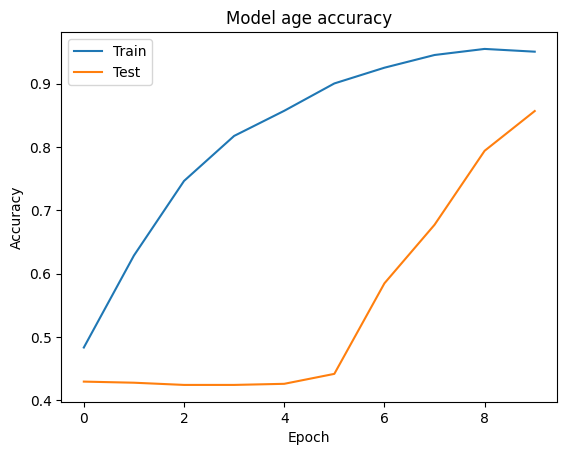

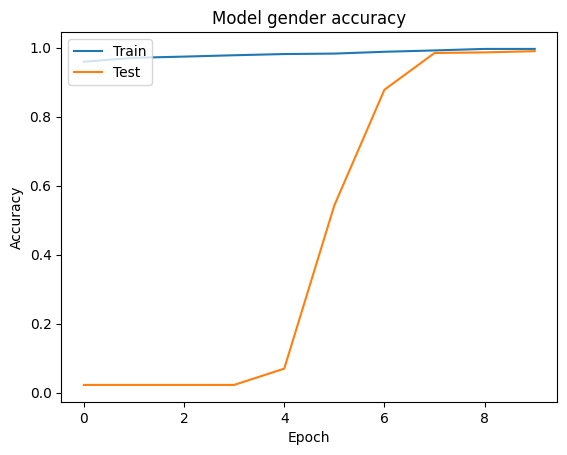

In [82]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['age_output_accuracy'])
plt.plot(history.history['val_age_output_accuracy'])
plt.title('Model age accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Model gender accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [83]:
# Evaluate the model
results = model.evaluate([X_test, X_test], {'age_output': y_test_age, 'gender_output': y_test_gender})


18/18 [==============================] - 1s 59ms/step - loss: 0.4563 - age_output_loss: 0.4321 - gender_output_loss: 0.0242 - age_output_accuracy: 0.8569 - gender_output_accuracy: 0.9895


In [84]:
# The results will contain overall loss, age_output loss, gender_output loss, age_output accuracy, and gender_output accuracy
loss, age_loss, gender_loss, age_accuracy, gender_accuracy = results
print(f'Overall Loss: {loss}')
print(f'Age Loss: {age_loss}')
print(f'Gender Loss: {gender_loss}')
print(f'Age Accuracy: {age_accuracy}')
print(f'Gender Accuracy: {gender_accuracy}')

Overall Loss: 0.45630723237991333
Age Loss: 0.4321030378341675
Gender Loss: 0.024204112589359283
Age Accuracy: 0.8568935394287109
Gender Accuracy: 0.9895287752151489


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report

# Make predictions
y_pred = model.predict([X_test, X_test])
y_pred_age = np.argmax(y_pred[0], axis=1)
y_pred_gender = (y_pred[1] > 0.5).astype(int)

# True labels
y_true_age = np.argmax(y_test_age, axis=1)
y_true_gender = y_test_gender

18/18 [==============================] - 2s 55ms/step


In [100]:
# Calculate metrics
age_f1 = f1_score(y_true_age, y_pred_age, average='weighted')
gender_f1 = f1_score(y_true_gender, y_pred_gender)
age_recall = recall_score(y_true_age, y_pred_age, average='weighted')
gender_recall = recall_score(y_true_gender, y_pred_gender)
age_conf_matrix = confusion_matrix(y_true_age, y_pred_age)
gender_conf_matrix = confusion_matrix(y_true_gender, y_pred_gender)

In [101]:
# Print additional metrics
print(f"Age F1 Score: {age_f1}")
print(f"Gender F1 Score: {gender_f1}")
print(f"Age Recall: {age_recall}")
print(f"Gender Recall: {gender_recall}")

print("Age Confusion Matrix:")
print(age_conf_matrix)
print("Gender Confusion Matrix:")
print(gender_conf_matrix)

Age F1 Score: 0.8609791542804515
Gender F1 Score: 0.9946714031971582
Age Recall: 0.8568935427574171
Gender Recall: 1.0
Age Confusion Matrix:
[[ 46   2   3   1   0   0   1   0]
 [  3  66   9   0   0   0   0   0]
 [  0   0 204  39   2   0   0   0]
 [  0   0  11  60   1   5   0   0]
 [  0   0   1   0  42   1   0   0]
 [  0   0   1   1   0  54   0   0]
 [  0   0   0   0   0   1  11   0]
 [  0   0   0   0   0   0   0   8]]
Gender Confusion Matrix:
[[  7   6]
 [  0 560]]


In [102]:
# Classification report
age_class_report = classification_report(y_true_age, y_pred_age, target_names=age_groups, output_dict=True)
gender_class_report = classification_report(y_true_gender, y_pred_gender, output_dict=True)

# Convert classification report to DataFrame for better visualization
age_class_report_df = pd.DataFrame(age_class_report).transpose()
gender_class_report_df = pd.DataFrame(gender_class_report).transpose()

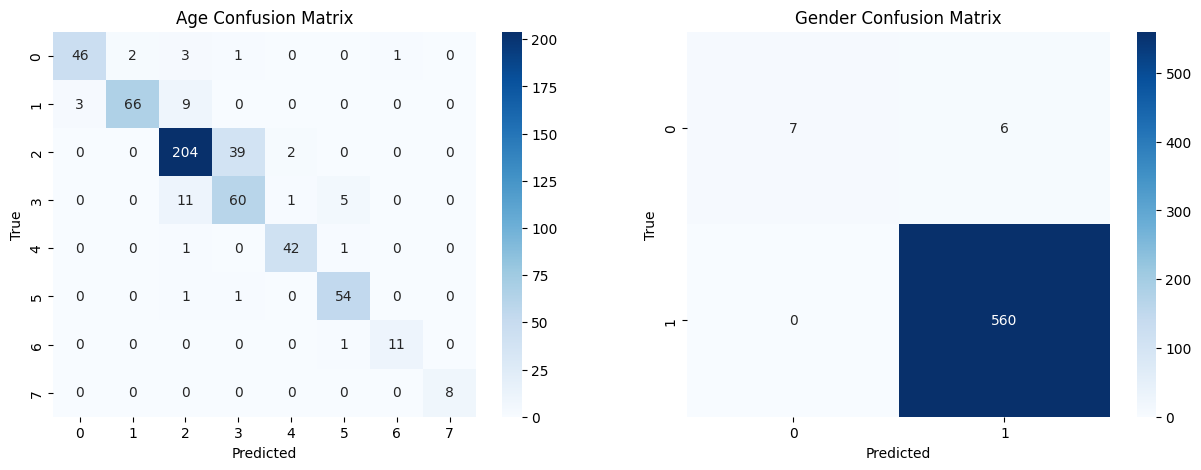

In [103]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(age_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Age Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(gender_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Gender Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.show()

In [105]:
# Display classification reports
print("Age Classification Report:")
print(age_class_report_df)

print("Gender Classification Report:")
print(gender_class_report_df)



Age Classification Report:
              precision    recall  f1-score     support
Age 1-10       0.938776  0.867925  0.901961   53.000000
Age 11-20      0.970588  0.846154  0.904110   78.000000
Age 21-30      0.890830  0.832653  0.860759  245.000000
Age 31-40      0.594059  0.779221  0.674157   77.000000
Age 41-50      0.933333  0.954545  0.943820   44.000000
Age 51-60      0.885246  0.964286  0.923077   56.000000
Age 61-70      0.916667  0.916667  0.916667   12.000000
Age 71-80      1.000000  1.000000  1.000000    8.000000
accuracy       0.856894  0.856894  0.856894    0.856894
macro avg      0.891187  0.895181  0.890569  573.000000
weighted avg   0.871025  0.856894  0.860979  573.000000
Gender Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.538462  0.700000   13.000000
1              0.989399  1.000000  0.994671  560.000000
accuracy       0.989529  0.989529  0.989529    0.989529
macro avg      0.994700  0.769231  0.847336  57

In [116]:
from IPython.display import display, HTML
# Display classification reports in a more presentable table format
def display_classification_report(df, title):
    display(HTML(f"<h2>{title}</h2>"))
    display(HTML(df.to_html()))

display_classification_report(age_class_report_df, "Age Classification Report")
display_classification_report(gender_class_report_df, "Gender Classification Report")


,precision,recall,f1-score,support
Age 1-10,0.938776,0.867925,0.901961,53.000000
Age 11-20,0.970588,0.846154,0.904110,78.000000
Age 21-30,0.890830,0.832653,0.860759,245.000000
Age 31-40,0.594059,0.779221,0.674157,77.000000
Age 41-50,0.933333,0.954545,0.943820,44.000000
Age 51-60,0.885246,0.964286,0.923077,56.000000
Age 61-70,0.916667,0.916667,0.916667,12.000000
Age 71-80,1.000000,1.000000,1.000000,8.000000
accuracy,0.856894,0.856894,0.856894,0.856894
macro avg,0.891187,0.895181,0.890569,573.000000


,precision,recall,f1-score,support
0,1.000000,0.538462,0.700000,13.000000
1,0.989399,1.000000,0.994671,560.000000
accuracy,0.989529,0.989529,0.989529,0.989529
macro avg,0.994700,0.769231,0.847336,573.000000
weighted avg,0.989640,0.989529,0.987986,573.000000


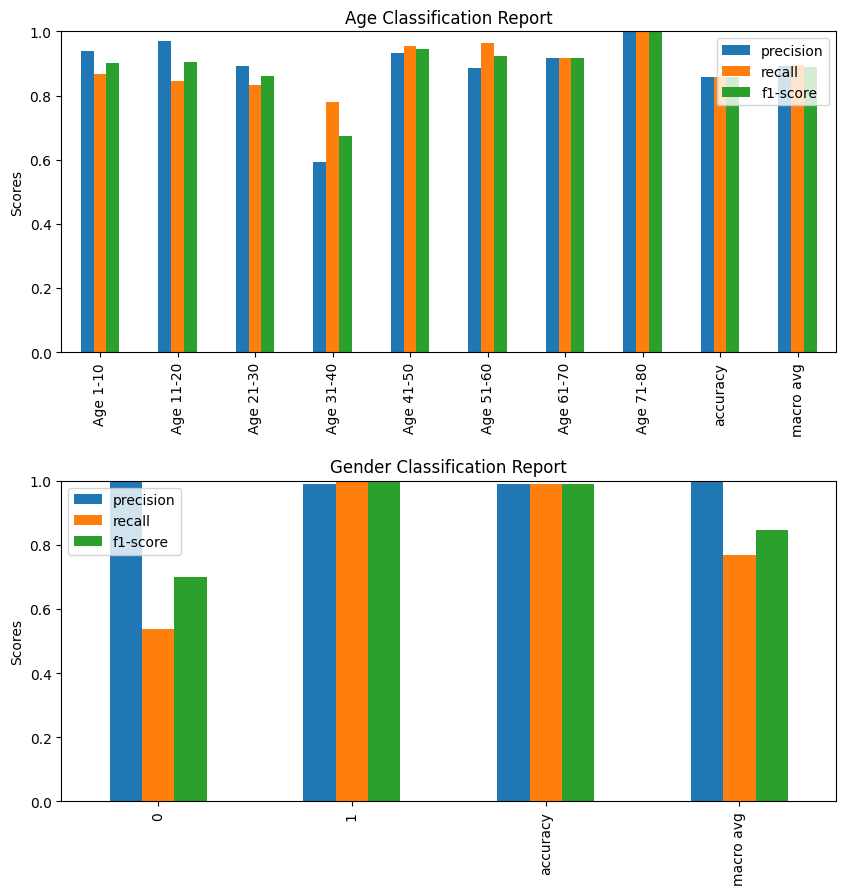

In [117]:
# Plot classification report as a bar chart for better visualization
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

age_class_report_df.iloc[:-1, :-1].plot(kind='bar', ax=axes[0])
axes[0].set_title('Age Classification Report')
axes[0].set_ylabel('Scores')
axes[0].set_ylim(0, 1)

gender_class_report_df.iloc[:-1, :-1].plot(kind='bar', ax=axes[1])
axes[1].set_title('Gender Classification Report')
axes[1].set_ylabel('Scores')
axes[1].set_ylim(0, 1)

# Adjust the space between plots
plt.subplots_adjust(hspace=0.4)  # Adjust hspace to your preference

plt.show()
